In [100]:
import mod
import dgl
from tqdm import tqdm

In [35]:
params = {
    'P': 2e5,
    'T0_so': 1e-14,
    'T0_sub': 0e0,
    't_range': [0,100],
    'pulsed': True,
    'f': 0.1,
    't_p': 1e0,
    'n': 10,
    'thick0': 0.0,
    }

def schichtdicke(P, t_end=100, t_p=None, n=10, pulsed=False):
    """
    Berechnet die Schichtdicke entweder bei kontinuierlichem oder bei gepulstem Betrieb.
    
    Parameters
    ----------
    P : float
        Laserleistung
    t_end : float
        Endzeitpunkt
    t_p : float
        Pulsdauer (optional)
    n : int
        Anzahl der Pulse (optional)
    pulsed : bool
        Gibt an, ob es sich um gepulsten Betrieb handelt (optional)
        
    Returns
    -------
    float
        Schichtdicke
    float
        Substrattemperatur
    """
    # erhebt Valuerror wenn t_p nicht angegeben ist, aber gepulster Betrieb gewünscht ist
    if pulsed and not t_p:
        raise ValueError("t_p is required for pulsed laser heating.")
    
    tm = TempMod(T_punkt)  # Initialisiert die Temperaturmodell-Klasse
    if pulsed:
        result = tm.mod(P=P, T0_so=params['T0_so'], T0_sub=params['T0_sub'], pulsed=pulsed, f=params['f'], t_p=t_p, n=n, gr_factor=c['gr_factor'], gr_exp=c['gr_exp'])
    else:
        result = tm.mod(P=P, T0_so=params['T0_so'], T0_sub=params['T0_sub'], t_range=[0, t_end], gr_factor=c['gr_factor'], gr_exp=c['gr_exp'])
    # Returnt die letzte Schichtdicke und die maximale Substrattemperatur
    return result['Thickness'][-1], result['Temp_substrate'].max()

def fehlerfunktion(t_p, P_const, P_pulse, t_end, n, cache={}):
    """
    Berechnet die Differenz zwischen den Schichtdicken des kontinuierlichen und des gepulsten Betriebs.
    
    Paramters
    ---------
    t_p : float
        Pulsdauer
    P_const : float
        Laserleistung im kontinuierlichen Betrieb
    P_pulse : float
        Laserleistung im gepulsten Betrieb
    t_end : float
        Endzeitpunkt
    n : int
        Anzahl der Pulse
    cache : dict
        Cache für die Fehlerfunktion (optional)
    
    Returns
    -------
    float
        Differenz der Schichtdicken
    """
    # Schlüssel für den Cache
    key = (t_p, P_const, P_pulse, t_end, n)
    if key in cache:
        return cache[key]  # Gibt gecachtes Ergebnis zurück, falls vorhanden
    # Berechnet nur die Differenz der Schichtdicken, die Temperatur wird hier ignoriert
    thickness_const, _ = schichtdicke(P_const, t_end)
    thickness_pulse, _ = schichtdicke(P_pulse, t_end, t_p, n, pulsed=True)
    diff = thickness_const - thickness_pulse
    cache[key] = diff
    return diff

def newton_verfahren(P_const, P_pulse, t_end, n, initial_t_p=1, tol=1e-8, max_iter=10000):
    """
    Verwendet das Newton-Verfahren, um die Pulsdauer t_p zu finden, bei der die Schichtdicke beim gepulsten Betrieb
    der beim kontinuierlichen Betrieb entspricht.
    
    Parameters
    ----------
    P_const : float
        Laserleistung im kontinuierlichen Betrieb
    P_pulse : float
        Laserleistung im gepulsten Betrieb
    t_end : float
        Endzeitpunkt
    n : int
        Anzahl der Pulse
    initial_t_p : float
        Startwert für die Pulsdauer (optional)
    tol : float
        Toleranz für die Konvergenz (optional)
    max_iter : int
        Maximale Anzahl an Iterationen (optional)
    
    Returns
    -------
    float
        Pulsdauer, bei der die Schichtdicke beim gepulsten Betrieb der beim kontinuierlichen Betrieb entspricht
    """
    t_p = initial_t_p  # Initialisiert t_p mit dem Startwert
    cache = {}  # Initialisiert den Cache für die Fehlerfunktion
    for i in range(max_iter):
        f_t_p = fehlerfunktion(t_p, P_const, P_pulse, t_end, n, cache=cache)  # Berechnet die Fehlerfunktion für t_p
        if abs(f_t_p) < tol:
            return t_p  # Konvergenz erreicht, gibt t_p zurück
        # Berechnet die Fehlerfunktion für einen leicht erhöhten Wert von t_p
        f_t_p_plus = fehlerfunktion(t_p + tol, P_const, P_pulse, t_end, n, cache=cache)
        print(f_t_p, f_t_p_plus)
        derivative = (f_t_p_plus - f_t_p) / tol  # Approximiert die Ableitung der Fehlerfunktion
        t_p -= f_t_p / derivative  # Aktualisiert t_p mit der Newton-Iteration
    return t_p  # Gibt den letzten Wert von t_p zurück, falls keine Konvergenz erreicht wurde

# Beispiel für die Anwendung der geänderten Funktion
t_p = [i*0.01 for i in range(1, 10)]
power = [i*100 for i in range(1, 10)]


colormap_data = []
colormap_data_thick = []
# Schleife über die Leistung und Pulsbreiten
print('Berechnung der Temperaturen läuft:')
for tp in t_p:
    for p in power:
        #print(p, tp)
        thickness_solved, temperature = schichtdicke(P=p, t_p=tp, pulsed=True)  # Gepulster Betrieb
        colormap_data.append(temperature)
        colormap_data_thick.append(thickness_solved)
print('Berechnung der Temperaturen ist fertig.')
# Schleife für die Berechnung der optimalen Pulsbreite
tp_opt = []

print('Tp_opt Berechnung läuft:')
for i in range(2, 10):
    print(f'Berechnung für {i} W:')
    for pow in tqdm(power):
        tp_opt.append(newton_verfahren(P_const=i*100, P_pulse=pow, t_end=10, n=10))
print('Tp_opt Berechnung ist fertig.')


Berechnung der Temperaturen läuft:
Berechnung der Temperaturen ist fertig.
Tp_opt Berechnung läuft:
Berechnung für 2 W:


  0%|          | 0/9 [00:00<?, ?it/s]

-21.33639966693901 -21.336399957533025
0.2588919826995024 0.2588916500366949
0.002140866765657279 0.002140539478354242
1.3495667872120976e-07 -1.9228865966169906e-07


 11%|█         | 1/9 [00:00<00:05,  1.49it/s]

-28.455571083584864 -28.455571424635956
0.18763793914383342 0.18763755144013317
0.0015397331499116262 0.001539351657179111
9.772589493195483e-08 -2.837202828231966e-07


 22%|██▏       | 2/9 [00:01<00:04,  1.42it/s]

-32.277398506710554 -32.27739887673968
0.14510597787111124 0.14510556351154236
0.0010356137663194431 0.001035205182247978
5.3908003394553816e-08 -3.5463585845718626e-07


 33%|███▎      | 3/9 [00:02<00:04,  1.42it/s]

-34.838686551215744 -34.83868694139716
0.11817029458535444 0.11816986416460651
0.0007149696121118154 0.000714544281422036
2.4906555040615785e-08 -4.0039446957962355e-07


 44%|████▍     | 4/9 [00:02<00:03,  1.39it/s]

-36.74159575902638 -36.741596164558956
0.09956953388028467 0.0995690925138959
0.0005066763436119004 0.0005062393699262202
1.2120473513732577e-08 -4.248311711307906e-07


 56%|█████▌    | 5/9 [00:03<00:02,  1.36it/s]

-38.24331590478286 -38.24331632264307
0.08726019886561431 0.0872597493061491


 67%|██████▋   | 6/9 [00:04<00:02,  1.44it/s]

0.00037881481603108114 0.00037836907406330056
-39.47654241753885 -39.476542845670124
0.07793829306032762 0.0779378370072692


 78%|███████▊  | 7/9 [00:04<00:01,  1.51it/s]

0.00028883204070950796 0.0002883792957817377
-40.51831117409523 -40.518311611000954
0.07107278096378167 0.07107231948429416


 89%|████████▉ | 8/9 [00:05<00:00,  1.55it/s]

0.00022681102102239947 0.00022635242391544352
-41.417138041866394 -41.41713848641156
0.06610369383577819 0.0661032276406388


100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


0.00018421866091244965 0.0001837550081447148
Berechnung für 3 W:


  0%|          | 0/9 [00:00<?, ?it/s]

-18.360539946485062 -18.36054023707908
0.05731218744667643 0.0573118895345317


 11%|█         | 1/9 [00:00<00:04,  1.77it/s]

2.1648167631838078e-05 2.1350482285242833e-05
-25.479711363130917 -25.47971170418201
0.038965559183537835 0.03896521401028963


 22%|██▏       | 2/9 [00:01<00:04,  1.75it/s]

6.525334399043459e-06 6.180276777456584e-06
-29.301538786256607 -29.301539156285735
0.03535150504887241 0.035351132559263476


 33%|███▎      | 3/9 [00:01<00:03,  1.68it/s]

3.0569894562404443e-06 2.684565814092821e-06
-31.862826830761797 -31.86282722094321
0.035071457326957045 0.0350710654844022


 44%|████▍     | 4/9 [00:02<00:03,  1.64it/s]

1.8115446422939385e-06 1.4197390285630718e-06
-33.765736038572435 -33.76573644410501
0.035160779794871644 0.03516037300040864


 56%|█████▌    | 5/9 [00:03<00:02,  1.64it/s]

1.005303744250341e-06 5.985311801737225e-07
-35.267456184328914 -35.26745660218912
0.03613438385036716 0.03613396492198717


 67%|██████▋   | 6/9 [00:03<00:01,  1.61it/s]

6.185922458712412e-07 1.996782046376211e-07
-36.500682697084905 -36.50068312521618
0.03662511038357508 0.03662468128846541


 78%|███████▊  | 7/9 [00:04<00:01,  1.59it/s]

2.5850201268440287e-07 -1.705843786226069e-07
-37.542451453641284 -37.54245189054701
0.037105129778929324 0.037104691962298375


 89%|████████▉ | 8/9 [00:04<00:00,  1.62it/s]

1.4790025915090155e-07 -2.8991027534175373e-07
-38.44127832141245 -38.44127876595761
0.03771188117317337 0.03771143574038405


100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


2.545215380678201e-07 -1.9090712299885126e-07
Berechnung für 4 W:


  0%|          | 0/9 [00:00<?, ?it/s]

-16.300047519316358 -16.300047809910374
0.02612981217823318 0.026129519129540313


 11%|█         | 1/9 [00:00<00:04,  1.68it/s]

1.441392683432241e-06 1.1483771586995317e-06
-23.419218935962213 -23.419219277013305
0.025238421025527202 0.025238078745779546


 22%|██▏       | 2/9 [00:01<00:04,  1.66it/s]

4.6700795053311595e-07 1.2474025368192088e-07
-27.241046359087903 -27.24104672911703
0.027468043475813886 0.027467672551132694


 33%|███▎      | 3/9 [00:01<00:03,  1.66it/s]

3.1662124655440493e-07 -5.4295263396397786e-08


 33%|███▎      | 3/9 [00:01<00:03,  1.54it/s]


KeyboardInterrupt: 

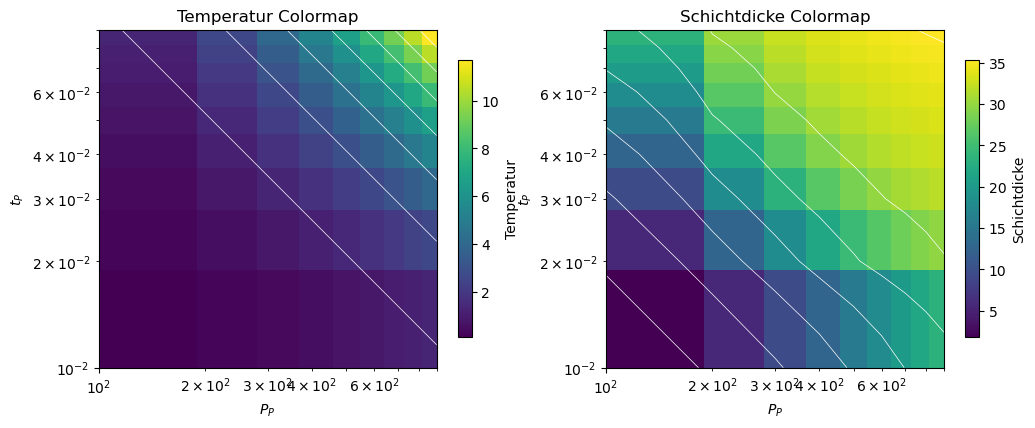

In [6]:
# Erstellen der Farbkarte mit Konturen
def create_colormap(power, pulse_durations, temperatures, thickness):
    # Erstellen des Meshgrids für die Leistung und die Pulsbreiten
    p, T_p = np.meshgrid(power, pulse_durations)
    # Konvertiert die Temperaturen in ein Array und formt es in die richtige Form (2D)
    Temperatures = np.array(temperatures).reshape(len(pulse_durations), len(power))
    thick = np.array(thickness).reshape(len(pulse_durations), len(power))
    # Erstellen der Farbkarte mit imshow
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Temperaturen mit Konturen
    im1 = ax[0].imshow(Temperatures, extent=(p.min(), p.max(), T_p.min(), T_p.max()), origin='lower', aspect='auto')
    contour1 = ax[0].contour(p, T_p, Temperatures, colors='white', linewidths=0.5)
    fig.colorbar(im1, label='Temperatur', ax=ax[0], shrink=0.6)
    ax[0].loglog()
    ax[0].set_aspect('equal')
    ax[0].set_xlabel('$P_P$')
    ax[0].set_ylabel('$t_P$')
    ax[0].set_title('Temperatur Colormap')
    
    # Dicke mit Konturen
    #im2 = ax[1].imshow(thick, interpolation='gaussian', extent=(p.min(), p.max(), T_p.min(), T_p.max()), origin='lower', aspect='equal')
    im2 = ax[1].imshow(thick, extent=(p.min(), p.max(), T_p.min(), T_p.max()), origin='lower', aspect='equal')
    contour2 = ax[1].contour(p, T_p, thick, colors='white', linewidths=0.5)
    fig.colorbar(im2, label='Schichtdicke', ax=ax[1], shrink=0.6)
    ax[1].loglog()
    ax[1].set_aspect('equal')
    ax[1].set_xlabel('$P_P$')
    ax[1].set_ylabel('$t_P$')
    ax[1].set_title('Schichtdicke Colormap')
    
    plt.show()

create_colormap(power, t_p, colormap_data, colormap_data_thick)


In [7]:
# Schleife für die Berechnung der optimalen Pulsbreite
tp_opt = []

print('Tp_opt Berechnung läuft:')
for i in range(2, 10):
    print(f'Berechnung für {i} W:')
    for pow in tqdm(power):
        tp_opt.append(newton_verfahren(P_const=i*100, P_pulse=pow, t_end=10, n=10))
print('Tp_opt Berechnung ist fertig.')

Tp_opt Berechnung läuft:
Berechnung für 2 W:


100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Berechnung für 3 W:


100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Berechnung für 4 W:


100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Berechnung für 5 W:


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Berechnung für 6 W:


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Berechnung für 7 W:


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


Berechnung für 8 W:


100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Berechnung für 9 W:


100%|██████████| 9/9 [00:05<00:00,  1.75it/s]

Tp_opt Berechnung ist fertig.


In [8]:
print(len(tp_opt)/len(power))
tp_opt = np.array(tp_opt).reshape(int(len(tp_opt)/len(power)), len(power))


8.0


In [9]:
print(tp_opt)

[[0.27361387 0.17053087 0.13123383 0.10987795 0.09625904 0.08673157
  0.07964904 0.0741525  0.06974745]
 [0.37009665 0.25403538 0.209078   0.18427938 0.16823739 0.15686125
  0.14829535 0.14156713 0.13611385]
 [0.43997005 0.31405965 0.264554   0.23694489 0.21893212 0.20606995
  0.19632868 0.18863866 0.18237802]
 [0.49349626 0.35981193 0.30675125 0.27696988 0.25744498 0.24344749
  0.23281047 0.22438848 0.2175139 ]
 [0.53653444 0.39653201 0.34060223 0.30907394 0.28833481 0.27342623
  0.26207054 0.25306135 0.24569428]
 [0.57236081 0.42707562 0.36875533 0.33577327 0.31402404 0.29835762
  0.28640419 0.27690662 0.26912993]
 [0.60294937 0.4531442  0.39278231 0.35855924 0.33594784 0.31963459
  0.30717098 0.29725656 0.28913028]
 [0.62957218 0.47582855 0.41368952 0.37838641 0.35502472 0.33814859
  0.32524101 0.31496386 0.30653335]]


9 8 81


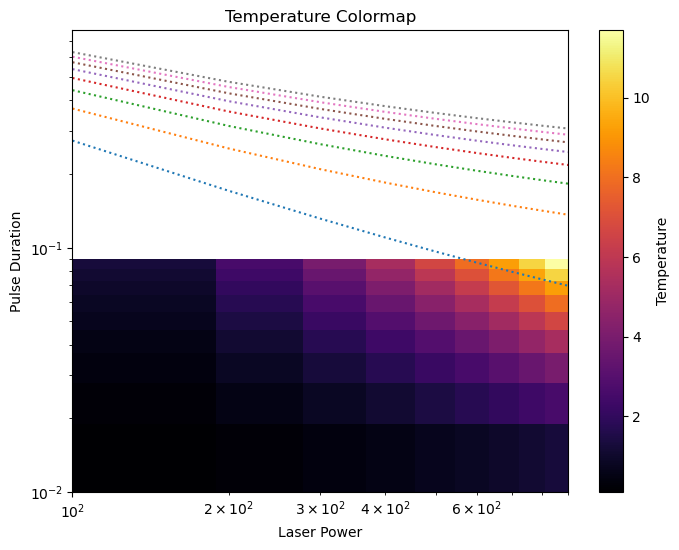

In [13]:
# Erstellen der Farbkarte
def create_colormap(power, pulse_durations, temperatures):
    # Erstellen des Meshgrids für die Leistung und die Pulsbreiten
    p, T_p = np.meshgrid(power, pulse_durations)
    # Konvertiert die Temperaturen in ein Array und formt es in die richtige Form (2D)
    Temperatures = np.array(temperatures).reshape(len(pulse_durations), len(power))
    # Erstellen der Farbkarte mit imshow
    plt.figure(figsize=(8, 6))
    plt.imshow(Temperatures, extent=(p.min(), p.max(), T_p.min(), T_p.max()), origin='lower', aspect='auto', cmap='inferno')
    for i in range(len(tp_opt)):
        plt.plot(power, tp_opt[i], ':', label=f'$t_P$ same thickness as const P={(i+10)*100 }W')
    plt.colorbar(label='Temperature')
    plt.loglog()
    plt.xlabel('Laser Power')
    plt.ylabel('Pulse Duration')
    plt.title('Temperature Colormap')
    #plt.legend()
    plt.show()

print(len(power), len(tp_opt), len(colormap_data))
create_colormap(power, t_p, colormap_data)

In [98]:
from scipy.optimize import newton
from scipy.optimize import bisect
params = {
    'P': 2e5,
    'T0_so': 1e-14,
    'T0_sub': 0e0,
    't_range': [0,100],
    'pulsed': True,
    'f': 0.1,
    't_p': 1e0,
    'n': 10,
    'thick0': 0.0,
    }

def schichtdicke(P, t_end=100, t_p=None, n=10, pulsed=False):

    # erhebt Valuerror 
    # wenn t_p nicht angegeben ist, aber gepulster Betrieb gewünscht ist
    if pulsed and not t_p:
        raise ValueError("t_p is required for pulsed laser heating.")
    
    tm = TempMod(T_punkt)  # Initialisiert die Temperaturmodell-Klasse
    if pulsed:
        result = tm.mod(P=P, T0_so=params['T0_so'], T0_sub=params['T0_sub'], pulsed=pulsed, f=params['f'], t_p=t_p, n=n, gr_factor=c['gr_factor'], gr_exp=c['gr_exp'])
    else:
        result = tm.mod(P=P, T0_so=params['T0_so'], T0_sub=params['T0_sub'], t_range=[0, t_end], gr_factor=c['gr_factor'], gr_exp=c['gr_exp'])
    # Returnt die letzte Schichtdicke und die maximale Substrattemperatur
    return result['Thickness'][-1], result['Temp_substrate'].max()

def fehlerfunktion(P_pulse, t_p, rate, t_end, n, cache={}):

    # Schlüssel für den Cache
    key = (t_p, rate, P_pulse, t_end, n)
    if key in cache:
        return cache[key]  # Gibt gecachtes Ergebnis zurück, falls vorhanden
    # Berechnet nur die Differenz der Schichtdicken, die Temperatur wird hier ignoriert
    thickness_const = rate * t_end
    thickness_pulse, _ = schichtdicke(P_pulse, t_end, t_p, n, pulsed=True)
    #print(thickness_pulse)
    diff = thickness_const - thickness_pulse
    cache[key] = diff
    return diff


def nullstellen(fehlerfunktion, a, b, args=()):
    bisektion = bisect(fehlerfunktion, a, b, args=args)
 
    nullstelle = newton(fehlerfunktion, bisektion, args=args)
    return nullstelle
z = nullstellen(y, 0, 1000, args=(-0.9, 4.2))
print(z)
# Beispiel für die Anwendung der geänderten Funktion
n = 3
t_p = [i*0.1 for i in range(1, n+1)]
rate_vals = [i*0.01 for i in range(1, n+1)]
p_opt = []
colormap_data = []
colormap_data_thick = []
print(t_p[0], rate_vals[0])

x=nullstellen(fehlerfunktion, 0, 1e3, args=(t_p[0], rate_vals[0], 10, 10))
print(x)
# Schleife für die Berechnung der optimalen Pulsbreite

#print('p_opt Berechnung läuft:')
#for i in range(len(rate_vals)):
#    print(f'Berechnung für t_p={i}s:')
#    for r in rate_vals:
#        p_opt.append(newton_verfahren(rate=r, t_end=10, n=10, t_p=i+1))
#print('p_opt Berechnung ist fertig.')
##print(p_opt)
## Schleife über die Leistung und Pulsbreiten
#print('Berechnung der Temperaturen läuft:')
#for tp in t_p:
#    for p in range(len(rate_vals)):
#        #print(p, tp)
#        thickness_solved, temperature = schichtdicke(P=p_opt[p], t_p=tp, pulsed=True)  # Gepulster Betrieb
#        colormap_data.append(temperature)
#        colormap_data_thick.append(thickness_solved)
#print('Berechnung der Temperaturen ist fertig.')

4.666666666666667
0.1 0.01
3.8659188850192727


9 3 3


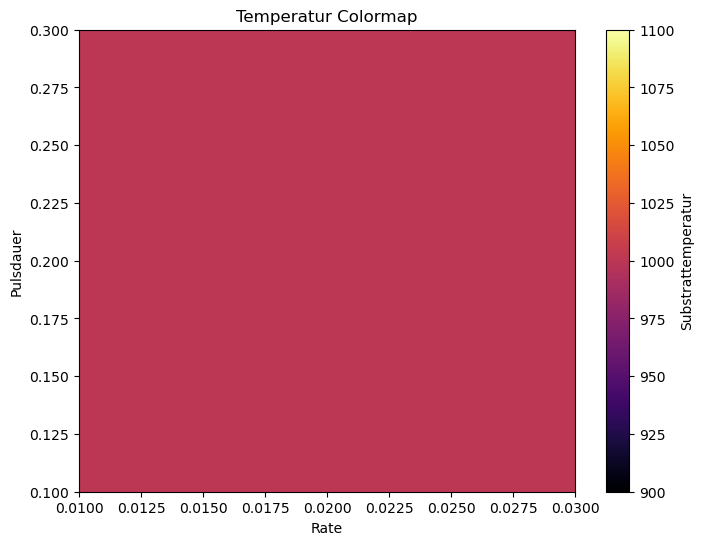

9 9
[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]


In [58]:
# Erstellen der Farbkarte
def create_colormap(rate, pulse_durations, p_opt):
    # Erstellen des Meshgrids für die Leistung und die Pulsbreiten
    p, T_p = np.meshgrid(rate, pulse_durations)
    # Konvertiert die Temperaturen in ein Array und formt es in die richtige Form (2D)
    Powers = np.array(p_opt).reshape(len(rate), len(pulse_durations))
    # Erstellen der Farbkarte mit imshow
    plt.figure(figsize=(8, 6))
    plt.imshow(Powers, extent=(p.min(), p.max(), T_p.min(), T_p.max()), origin='lower', aspect='auto', cmap='inferno')
    #for i in range(len(p_opt)):
        #plt.plot(power, p_opt[i], ':', label=f'$t_P$ same thickness as const P={(i+10)*100 }W')
    plt.colorbar(label='Substrattemperatur')
    #plt.loglog()
    plt.xlabel('Rate')
    plt.ylabel('Pulsdauer')
    plt.title('Temperatur Colormap')
    #plt.legend()
    plt.show()

print(len(p_opt), len(rate_vals), len(t_p))
create_colormap(rate_vals, t_p, p_opt)
print(len(colormap_data), len(colormap_data_thick))
print(p_opt)